# This notebook has the sole purpose to reproduce the results of the models used.

First we need to download the **models** and the **ground truth** images from google drive.

## Google Drive

### Requirements

We need to install library **down**, that helps download files from google drive.

In [ ]:
!pip install gdown

### Downloader

In [17]:
import gdown
from zipfile import ZipFile

demo_images = 'https://drive.google.com/file/d/1SpxA6lbxnJTsN51TiCcGWRLxDQ8P6l1g/view?usp=sharing'
ESRGAN = 'https://drive.google.com/file/d/1qrwUmyzggJc-NbwnfADH4MyXlHEDx2Ua/view?usp=sharing'
iSeeBetterAPIT = 'https://drive.google.com/file/d/1_HsjJhAkKVLLPfez78KMHk7V9sz8VncJ/view?usp=sharing'
iSeeBetterMAE = 'https://drive.google.com/file/d/1AA1no-tPJVKhum2O3za3qxpw42Nyz2wF/view?usp=sharing'
destination = os.getcwd()
gdown.download(iSeeBetterMAE, output_path, quiet=False,fuzzy=True)

# Download ESRGAN
gdown.download(ESRGAN, os.path.join(destination, "generator_32.pth"), quiet=False,fuzzy=True)

# Download iSeeBetter APIT
gdown.download(iSeeBetterAPIT, os.path.join(destination, "APIT_netG_epoch_15_4x.pth"), quiet=False,fuzzy=True)

# Download iSeeBetter MAE
gdown.download(iSeeBetterMAE, os.path.join(destination, "MAE_netG_epoch_5_4x.pth"), quiet=False,fuzzy=True)

# Download demo images and unzip
gdown.download(demo_images, os.path.join(destination, "demo.zip"), quiet=False,fuzzy=True)
with ZipFile("demo.zip", 'r') as zip_ref:
    zip_ref.extractall(destination)

Downloading...
From: https://drive.google.com/uc?id=1AA1no-tPJVKhum2O3za3qxpw42Nyz2wF
To: /work3/s213685/iSeeBetter-pytorch/MAE_netG_epoch_5_4x.pth
100%|██████████████████████████████████████████████████████████████████████████| 51.1M/51.1M [00:00<00:00, 93.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qrwUmyzggJc-NbwnfADH4MyXlHEDx2Ua
To: /work3/s213685/iSeeBetter-pytorch/generator_32.pth
100%|█████████████████████████████████████████████████████████████████████████████| 154M/154M [00:01<00:00, 103MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_HsjJhAkKVLLPfez78KMHk7V9sz8VncJ
To: /work3/s213685/iSeeBetter-pytorch/APIT_netG_epoch_15_4x.pth
100%|██████████████████████████████████████████████████████████████████████████| 51.1M/51.1M [00:00<00:00, 93.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1AA1no-tPJVKhum2O3za3qxpw42Nyz2wF
To: /work3/s213685/iSeeBetter-pytorch/MAE_netG_epoch_5_4x.pth
100%|█████████████████████████████████████████████████████████

In [102]:
from ESRGAN.implementations.esrgan.models import GeneratorRRDB
from ESRGAN.implementations.esrgan.datasets import denormalize, mean, std

import torch
from torch.autograd import Variable

# import os
# import numpy as np
# import math
# import cv2
from PIL import Image
from skimage.metrics import structural_similarity

from torchvision import transforms
from torchvision.utils import save_image
from torchmetrics.functional import structural_similarity_index_measure
from torchmetrics import PeakSignalNoiseRatio

%matplotlib inline
import matplotlib.pyplot as plt

## Upload image to test on 

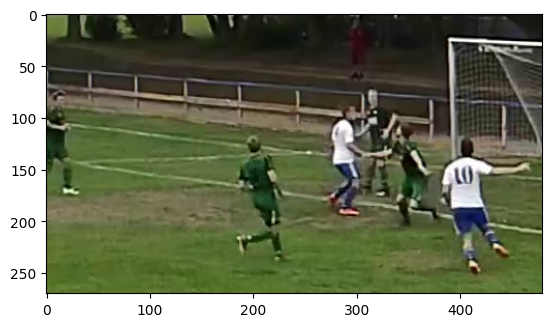

In [21]:
# Change the path to the path of the image you want to upscale
demo = "demo"
image_id = "94.png"
image_path = os.path.join(demo, image_id)
image = Image.open(image_path)
imgplot = plt.imshow(image)
plt.show()

# Get image parameters
(im_width, im_height) = image.size
im_channels = len(image.getbands())

In [5]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## ESRGAN

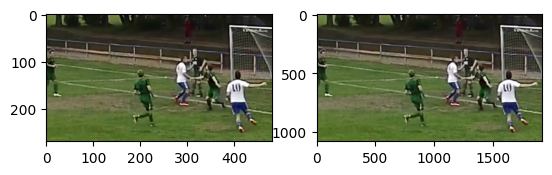

In [107]:
# Define model and load model checkpoint
model_path = "generator_32.pth"
generator = GeneratorRRDB(im_channels, filters=64, num_res_blocks=23, num_upsample=2).to(device)
generator.load_state_dict(torch.load(model_path))
generator.eval()

# Transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

### Prepare input ###
# Just upscale image
image_tensor = Variable(transform(image)).to(device).unsqueeze(0)
# # Downscale and upscale image
# image_tensor = Variable(transform(image.resize((int(im_width/4),int(im_height/4))))).to(device).unsqueeze(0)

# Get SR image
with torch.no_grad():
    sr_image = denormalize(generator(image_tensor)).cpu()

# Save image
save_image(sr_image, "esrgan.png")

# Load image
esrgan_image_path = "esrgan.png"
sr_image = Image.open(esrgan_image_path)

# Plot images next to each other
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image)
axarr[1].imshow(sr_image)

## iSeeBetter

### Constants

In [1]:
iSeeBetterDir = "iSeeBetter"

In [2]:
import torch
from torch.autograd import Variable

# import os
# import numpy as np
# import math
# import cv2
from PIL import Image
from skimage.metrics import structural_similarity

from torchvision import transforms
from torchvision.utils import save_image
%matplotlib inline
import matplotlib.pyplot as plt

### Imports

#### Add module to path

In [3]:
import os
import sys
directory_path = os.path.abspath(os.path.join('.'))
iSeeBetterPath = os.path.join(directory_path, iSeeBetterDir)
if iSeeBetterPath not in sys.path:
    sys.path.append(iSeeBetterPath)

In [1]:
from __future__ import print_function
import argparse

import os
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
from rbpn import Net as RBPN
from data import get_test_set
import numpy as np
import utils
import time
import cv2
import math
from skimage.metrics import structural_similarity as ssim

### Helpers

In [2]:
def eval(args):
    
    gpus_list = range(args.gpus)

    cuda = args.gpu_mode
    if cuda:
        print("Using GPU mode")
        if not torch.cuda.is_available():
            raise Exception("No GPU found, please run without --gpu_mode")

    torch.manual_seed(args.seed)
    if cuda:
        torch.cuda.manual_seed(args.seed)

    print("==> Loading datasets")
    test_set = get_test_set(
        args.data_dir,
        args.nFrames,
        args.upscale_factor,
        args.file_list,
        args.other_dataset,
        args.future_frame,
        args.upscale_only,
    )
    testing_data_loader = DataLoader(
        dataset=test_set,
        num_workers=args.threads,
        batch_size=args.testBatchSize,
        shuffle=False,
    )

    print("==> Building model ", args.model_type)
    if args.model_type == "RBPN":
        model = RBPN(
            num_channels=3,
            base_filter=256,
            feat=64,
            num_stages=3,
            n_resblock=5,
            nFrames=args.nFrames,
            scale_factor=args.upscale_factor,
        )

    # if cuda:
    #    model = torch.nn.DataParallel(model, device_ids=gpus_list)

    device = torch.device("cuda:0" if cuda and torch.cuda.is_available() else "cpu")

    if cuda:
        model = model.cuda(gpus_list[0])

    # Initialize Logger

    # print iSeeBetter architecture
    utils.printNetworkArch(netG=model, netD=None)

    # load model
    modelPath = os.path.join(args.model)
    utils.loadPreTrainedModel(gpuMode=args.gpu_mode, model=model, modelPath=modelPath)

    model.eval()
    count = 0
    upscale_only = args.upscale_only
    if not upscale_only:
        avg_psnr_predicted = 0.0
        avg_ssim = 0.0
    for batch in testing_data_loader:
        input, target, neigbor, flow, bicubic = (
            batch[0],
            batch[1],
            batch[2],
            batch[3],
            batch[4],
        )

        with torch.no_grad():
            if cuda:
                input = Variable(input).cuda(gpus_list[0])
                bicubic = Variable(bicubic).cuda(gpus_list[0])
                neigbor = [Variable(j).cuda(gpus_list[0]) for j in neigbor]
                flow = [Variable(j).cuda(gpus_list[0]).float() for j in flow]
            else:
                input = Variable(input).to(device=device, dtype=torch.float)
                bicubic = Variable(bicubic).to(device=device, dtype=torch.float)
                neigbor = [
                    Variable(j).to(device=device, dtype=torch.float) for j in neigbor
                ]
                flow = [Variable(j).to(device=device, dtype=torch.float) for j in flow]

        t0 = time.time()
        if args.chop_forward:
            with torch.no_grad():
                prediction = chop_forward(
                    input, neigbor, flow, model, args.upscale_factor, nGPUs=args.gpus
                )
        else:
            with torch.no_grad():
                prediction = model(input, neigbor, flow)

        if args.residual:
            prediction = prediction + bicubic

        t1 = time.time()
        print("==> Processing: %s || Timer: %.4f sec." % (str(count), (t1 - t0)))
        save_img(
            prediction.cpu().data,
            str(count),
            True,
            output=args.output,
            file_list=args.file_list,
            upscale_factor=args.upscale_factor,
            model_type=args.model_type,
            nFrames=args.nFrames,
        )
        save_img(
            target,
            str(count),
            False,
            output=args.output,
            file_list=args.file_list,
            upscale_factor=args.upscale_factor,
            model_type=args.model_type,
            nFrames=args.nFrames,
        )

        prediction = prediction.cpu()
        prediction = prediction.data[0].numpy().astype(np.float32)
        prediction = prediction * 255.0

        target = target.squeeze().numpy().astype(np.float32)
        target = target * 255.0

        if not upscale_only:
            psnr_predicted = PSNR(prediction, target, shave_border=args.upscale_factor)
            ssim_cur = ssim(prediction, target, channel_axis=0)
            print("PSNR Predicted = ", psnr_predicted)
            print("SSIM Predicted = ", ssim_cur)
            avg_psnr_predicted += psnr_predicted
            avg_ssim += ssim_cur
        count += 1

    if not upscale_only:  # Otherwise the print will error on '-u'
        print("Avg PSNR Predicted = ", avg_psnr_predicted / count)
        print("Avg SSIM Predicted = ", avg_ssim / count)


def save_img(
    img, img_name, pred_flag, output, file_list, upscale_factor, model_type, nFrames
):
    save_img = img.squeeze().clamp(0, 1).numpy().transpose(1, 2, 0)

    # save img
    save_dir = os.path.join(
        output, os.path.splitext(file_list)[0] + "_" + str(upscale_factor) + "x"
    )
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    if pred_flag:
        save_fn = (
            save_dir + "/" + img_name + "_" + model_type + "F" + str(nFrames) + ".png"
        )
    else:
        save_fn = save_dir + "/" + img_name + ".png"
    cv2.imwrite(
        save_fn,
        cv2.cvtColor(save_img * 255, cv2.COLOR_BGR2RGB),
        [cv2.IMWRITE_PNG_COMPRESSION, 0],
    )


def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[1:3]
    pred = pred[
        :,
        1 + shave_border : height - shave_border,
        1 + shave_border : width - shave_border,
    ]
    gt = gt[
        :,
        1 + shave_border : height - shave_border,
        1 + shave_border : width - shave_border,
    ]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff**2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)


def chop_forward(x, neigbor, flow, model, scale, nGPUs, shave=8, min_size=2000):
    b, c, h, w = x.size()
    h_half, w_half = h // 2, w // 2
    h_size, w_size = h_half + shave, w_half + shave
    inputlist = [
        [
            x[:, :, 0:h_size, 0:w_size],
            [j[:, :, 0:h_size, 0:w_size] for j in neigbor],
            [j[:, :, 0:h_size, 0:w_size] for j in flow],
        ],
        [
            x[:, :, 0:h_size, (w - w_size) : w],
            [j[:, :, 0:h_size, (w - w_size) : w] for j in neigbor],
            [j[:, :, 0:h_size, (w - w_size) : w] for j in flow],
        ],
        [
            x[:, :, (h - h_size) : h, 0:w_size],
            [j[:, :, (h - h_size) : h, 0:w_size] for j in neigbor],
            [j[:, :, (h - h_size) : h, 0:w_size] for j in flow],
        ],
        [
            x[:, :, (h - h_size) : h, (w - w_size) : w],
            [j[:, :, (h - h_size) : h, (w - w_size) : w] for j in neigbor],
            [j[:, :, (h - h_size) : h, (w - w_size) : w] for j in flow],
        ],
    ]

    if w_size * h_size < min_size:
        outputlist = []
        for i in range(0, 4, nGPUs):
            with torch.no_grad():
                input_batch = inputlist[i]  # torch.cat(inputlist[i:(i + nGPUs)], dim=0)
                output_batch = model(input_batch[0], input_batch[1], input_batch[2])
            outputlist.extend(output_batch.chunk(nGPUs, dim=0))
    else:
        outputlist = [
            chop_forward(
                patch[0], patch[1], patch[2], model, scale, shave, min_size, nGPUs
            )
            for patch in inputlist
        ]

    h, w = scale * h, scale * w
    h_half, w_half = scale * h_half, scale * w_half
    h_size, w_size = scale * h_size, scale * w_size
    shave *= scale

    with torch.no_grad():
        output = Variable(x.data.new(b, c, h, w))
    output[:, :, 0:h_half, 0:w_half] = outputlist[0][:, :, 0:h_half, 0:w_half]
    output[:, :, 0:h_half, w_half:w] = outputlist[1][
        :, :, 0:h_half, (w_size - w + w_half) : w_size
    ]
    output[:, :, h_half:h, 0:w_half] = outputlist[2][
        :, :, (h_size - h + h_half) : h_size, 0:w_half
    ]
    output[:, :, h_half:h, w_half:w] = outputlist[3][
        :, :, (h_size - h + h_half) : h_size, (w_size - w + w_half) : w_size
    ]

    return output

In [3]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

### APIT Loss 

In [4]:
args = {
    "model": "APIT_netG_epoch_15_4x.pth",
    "output": os.path.join('results', 'APIT'),
    "upscale_factor": 4,
    "residual": False,
    "gpu_mode": True,
    "testBatchSize": 1,
    "chop_forward": False,
    'threads': 4,
    'seed': 123,
    'gpus': 1,
    'data_dir': "demo",
    'file_list': "sep_testlist.txt",
    'other_dataset': True,
    'future_frame': True,
    'nFrames': 7,
    'model_type': "RBPN",
    'debug': False,
    'upscale_only': True
}

args = dotdict(args)
eval(args)

Using GPU mode
==> Loading datasets
==> Building model  RBPN
Pre-trained SR model loaded from: APIT_netG_epoch_15_4x.pth
==> Processing: 0 || Timer: 3.5703 sec.


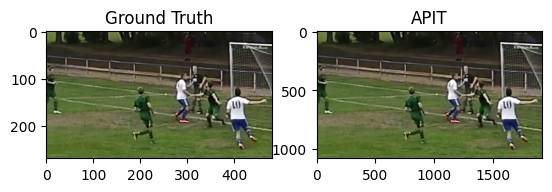

In [14]:
# output image is in folder 'results/APIT/sep_testlist_4x' with default name '0_RBPNF7.png'
apit_image_path = os.path.join('results', 'APIT', 'sep_testlist_4x', '0_RBPNF7.png')
apit_image = Image.open(apit_image_path)

# Plot images next to each other
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image)
axarr[0].title.set_text('Ground Truth')
axarr[1].imshow(apit_image)
axarr[1].title.set_text('APIT')

### MAE Loss 

In [16]:
args = {
    "model": "MAE_netG_epoch_5_4x.pth",
    "output": os.path.join('results', 'MAE'),
    "upscale_factor": 4,
    "residual": False,
    "gpu_mode": True,
    "testBatchSize": 1,
    "chop_forward": False,
    'threads': 4,
    'seed': 123,
    'gpus': 1,
    'data_dir': "demo",
    'file_list': "sep_testlist.txt",
    'other_dataset': True,
    'future_frame': True,
    'nFrames': 7,
    'model_type': "RBPN",
    'debug': False,
    'upscale_only': True
}

args = dotdict(args)
eval(args)

Using GPU mode
==> Loading datasets
==> Building model  RBPN
Pre-trained SR model loaded from: MAE_netG_epoch_5_4x.pth
==> Processing: 0 || Timer: 5.6031 sec.


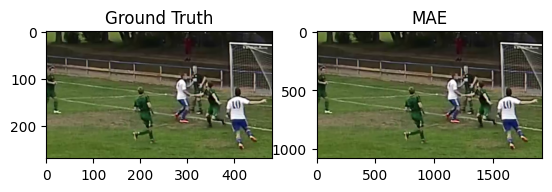

In [22]:
# output image is in folder 'results/MAE/sep_testlist_4x' with default name '0_RBPNF7.png'
mae_image_path = os.path.join('results', 'MAE', 'sep_testlist_4x', '0_RBPNF7.png')
mae_image = Image.open(mae_image_path)

# Plot images next to each other
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image)
axarr[0].title.set_text('Ground Truth')
axarr[1].imshow(mae_image)
axarr[1].title.set_text('MAE')